# Kaya identity 


$CO_2 = P \times \frac{GDP}{P} \times \frac{E}{GDP} \times \frac{CO_2}{E}$ ([wikipedia](https://en.wikipedia.org/wiki/Kaya_identity))

with:
- P: population
- GDP: Gross Domestic Product
- E: primary energy consumption
- $CO_2$: carbon dioxyde emissions


Sources:
- [Primary energy consumption](https://ourworldindata.org/energy-production-consumption#total-energy-consumption)
- [Population](https://ourworldindata.org/grapher/population-of-all-world-regions-including-the-un-projection-until-2100?country=OWID_WRL~Asia~Africa~Europe~South+America~Northern+America)
- [CO<sub>2</sub> emissions](https://ourworldindata.org/grapher/annual-co2-emissions-per-country?tab=chart&country=~OWID_WRL)
-[Imported or exported CO<sub>2</sub> emissions](https://ourworldindata.org/grapher/imported-or-exported-co-emissions-per-capita)
- [Greenhouse gas emissions](https://ourworldindata.org/grapher/total-ghg-emissions?tab=chart&country=~OWID_WRL)
- [GDP](https://ourworldindata.org/grapher/gross-domestic-product)

## Packages and useful functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,6)

from ipywidgets import interact
import ipywidgets as widgets

In [98]:
def selectCountry(df, country):
    mask = df['Entity'] == country
    return df[mask]

def selectYear(df, year):
    mask = df['Year'] == year
    return df[mask]

def getVariation(df, var):
    variation = 100 * np.diff(df[var]) / df[var].to_numpy()[0:-1]
    df[var+' variation'] = np.insert(variation, 0, None)
    return df

def plotEvolution(df_orig, var, unit, var_nom, var_denom, rolling_period=5, goal_2050=None, variation_2050=None):
    df = df_orig.copy()
    df[var] = df[var_nom] / df[var_denom]
    df[var] = df[var].rolling(rolling_period).mean()
    df = getVariation(df, var)

    fig, ax1 = plt.subplots()
    ax1.plot(df['Year'], df[var], color='black')
    ax1.set_ylabel(f'{var} ({unit})', color='black', fontsize=18)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0,None)

    ax2 = ax1.twinx()
    ax2.plot(df['Year'], df[f'{var} variation'], color='red')
    ax2.set_ylabel(f'{var} variation (%)', color='red', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.grid()   
    
    if goal_2050 is not None:
        lns1 = ax1.plot([df['Year'].iloc[-1], 2050], [df[var].iloc[-1], goal_2050],
                         '--', color='black', label='Goal 2050')
        proj_2050 = df[var].iloc[-1] * (1 + variation_2050/100)**(2050-df['Year'].iloc[-1])
        lns2 = ax1.plot([df['Year'].iloc[-1], 2050], [df[var].iloc[-1], proj_2050],
                          ':', color='black', label='Projection 2050')
        lns3 = ax2.plot([df['Year'].iloc[-1], 2050], [variation_2050, variation_2050],
                         ':', color='red', label='Projected variation')
        
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]      
        ax1.legend(lns, labs)


## Data preparation

In [107]:
df_co2 = pd.read_csv('input/annual-co2-emissions-per-country.csv')
df_co2_trade = pd.read_csv('input/imported-or-exported-co-emissions-per-capita.csv')
df_e = pd.read_csv('input/primary-energy-cons.csv')
df_pop = pd.read_csv('input/population-of-all-world-regions-including-the-un-projection-until-2100.csv')
df_gdp = pd.read_csv('input/gross-domestic-product.csv')

In [108]:
df_merge = pd.merge(df_co2, df_co2_trade, on=['Entity','Year','Code'])
df_merge = pd.merge(df_merge, df_pop, on=['Entity','Year','Code'])
df_merge = pd.merge(df_merge, df_e, on=['Entity','Year','Code'])
df_merge = pd.merge(df_merge, df_gdp, on=['Entity','Year','Code'])

In [109]:
# compute co2 print = territorial emissions + imports - exports
df_merge['Annual CO2 emissions'] = (df_merge['Annual CO2 emissions'] + 
                                    df_merge['Annual CO2 emissions embedded in trade (per capita)'] * 
                                    df_merge['Estimates, 1950 - 2020: Total population by broad age group, both sexes combined (thousands) - Total']
                                   )
df_merge['Annual CO2 emissions'] = df_merge['Annual CO2 emissions'] * 10**6 # change unit from t to g
df_merge['Primary energy consumption (kWh)'] = df_merge['Primary energy consumption (TWh)'] * 10**9

## Data visualisation

In [91]:
country = 'France'
df_merge_country = selectCountry(df_merge, country)
#df_co2_country = selectCountry(df_co2, country)
#df_e_country = selectCountry(df_e, country)
#df_pop_country = selectCountry(df_pop, country)
#df_gdp_country = selectCountry(df_gdp, country)

### Carbon intensity of primary energy consumption ($\frac{CO_2}{E}$)

$CO_2$ emitted when consuming one kWh of primary energy

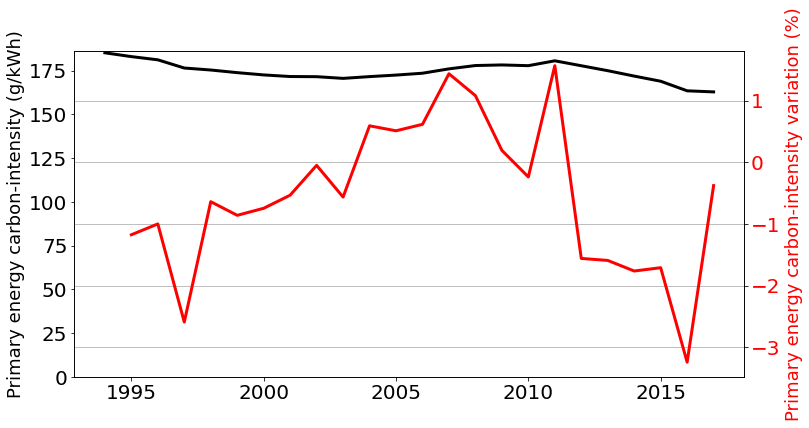

In [99]:
plotEvolution(df_merge_country, 'Primary energy carbon-intensity',
             'g/kWh', 'Annual CO2 emissions', 'Primary energy consumption (kWh)')

### Energy intensity of GDP ($\frac{E}{GDP}$)

Primary energy consumed to create one $ of GDP

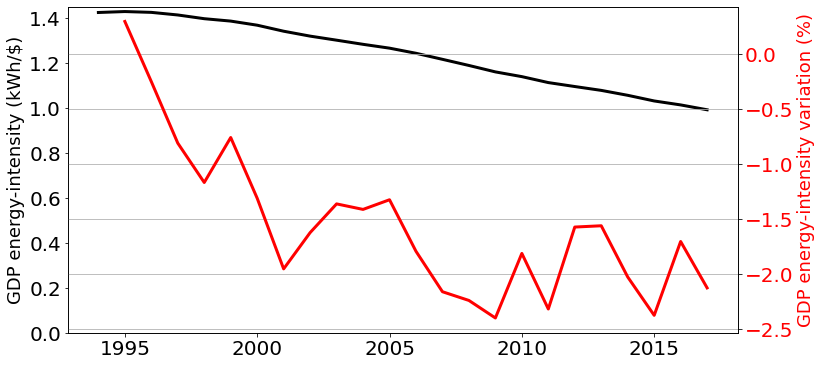

In [100]:
plotEvolution(df_merge_country, 'GDP energy-intensity', 'kWh/$',
              'Primary energy consumption (kWh)', 'GDP (constant 2010 US$)')

### Carbon intensity of GDP

$CO_2$ emitted to create one $ of GDP

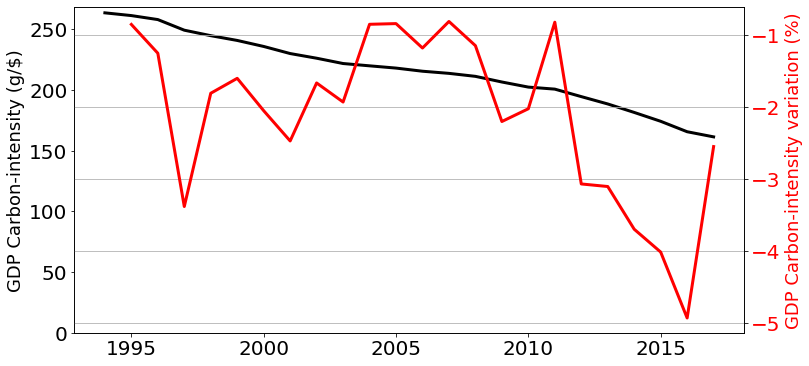

In [102]:
plotEvolution(df_merge_country, 'GDP Carbon-intensity', 'g/$',
              'Annual CO2 emissions', 'GDP (constant 2010 US$)')

## 2050: Projection vs Goal

- Technological progress decreases the carbon intensity of GDP, i.e. the same amount of wealth can be created with less $CO_2$ emissions.  
- The absolute $CO_2$ emissions (and other GHGs, not included here) need to be drastically cut until 2050 ([Emission scenarios from IPCC](https://data.ceda.ac.uk/badc/ar6_wg1/data/spm/spm_04/v20210809)).  
- The current economical system demands GDP growth. Virtually all policies currently implemented worldwide, and future plans, do not question the growth dogma.

**What level of GDP growth is compatible with Carbon Neutrality in 2050?**  
**What amount of "technological progress" is needed to be compatible with Carbon Neutrality in a GDP growth scenario?**

In this interactive plot, you can determine the 2050 goal for the carbon intensity of GDP $\frac{CO_2}{GDP}$ by fixing the following parameters:
- the temperature increase in 2100 relative to 1850-1900, among scenarios presented in the IPCC report (2021). From this a goal for worldwide $CO_2$ emissions in 2050 is extracted. It is assumed that each human should be allowed the same carbon print in 2050. As a consequence. the $CO_2$-emissions goal for a specific country is computed as: $CO_2(country) = CO_2(world) \times \frac{\text{population}(country)}{\text{population}(world)}$;
- the factor by which the world population will be multiplied in 2050 compared to now;
- the factor by which the population of the considered country will be multiplied in 2050 compared to now;
- the desired GDP growth, assumed to be constant from now to 2050.

The $\frac{CO_2}{GDP}$ goal can be compared to a projection based on another adjustable parameter: the expected variation of the carbon intensity of GDP, assumed to be constant from now to 2050.

In [55]:
# get dataset for IPCC Co2-emission scenarios
df_rcp = pd.read_csv('https://dap.ceda.ac.uk/badc/ar6_wg1/data/spm/spm_04/v20210809/panel_a/Carbon_dioxide_Gt_CO2_yr.csv')

# global warming (2100) corresponding to scenarios
gw_rcp = {
    '1.4' : 'ssp119',
    '1.8' : 'ssp126',
    '2.7' : 'ssp245',
    '3.6' : 'ssp370',
    '4.4' : 'ssp585',
}

In [110]:
@interact

def projection(country=widgets.Dropdown(options=df_co2['Entity'].unique(), value='France'),
               global_warming=widgets.Dropdown(options=gw_rcp.keys(), value='1.8'),
               world_pop_factor=widgets.FloatSlider(min=0.5, max=1.5, step=0.1, value=1.2),
               country_pop_factor=widgets.FloatSlider(min=0.5, max=1.5, step=0.1, value=1.1),
               gdp_growth=widgets.FloatSlider(min=-3, max=3, step=0.1, value=2),
               variation=widgets.FloatSlider(min=-6, max=-1, step=0.1, value=-2.5)):

    df_merge_country = selectCountry(df_merge, country)
    df_pop_world = selectCountry(df_pop, 'World')
    
    year = df_gdp_country['Year'].max()

    co2 = float(selectYear(df_merge_country, year)['Annual CO2 emissions'])
    gdp = float(selectYear(df_merge_country, year)['GDP (constant 2010 US$)'])
    pop_country = float(selectYear(df_merge_country, year)['Estimates, 1950 - 2020: Total population by broad age group, both sexes combined (thousands) - Total'])
    pop_world = float(selectYear(df_pop_world, year)['Estimates, 1950 - 2020: Total population by broad age group, both sexes combined (thousands) - Total'])
    gdp_pop = gdp / pop_country
    
    gdp_2050 = gdp * (1 + gdp_growth/100)**(2050-year)
    pop_country_2050 = pop_country * country_pop_factor
    pop_world_2050 = pop_world * world_pop_factor
    gdp_pop_2050 = gdp_2050 / pop_country_2050
    co2_world_2050 = float(df_rcp[df_rcp['years'] == 2050][gw_rcp[global_warming]]) * 10**15
    co2_country_2050 = co2_world_2050 * pop_country_2050 / pop_world_2050

    co2_gdp_2050 = co2_country_2050 / gdp_2050
    
    print(f'Parameter: {year} value --> 2050 value')
    print(f'CO2 emissions (Mt): {co2/10**12:.1f} --> {co2_country_2050/10**12:.1f}')
    print(f'World population (Millions): {pop_world/10**6:.1f} --> {pop_world_2050/10**6:.1f}')
    print(f'{country} population (Millions): {pop_country/10**6:.1f} --> {pop_country_2050/10**6:.1f}')
    print(f'CO2 per capita (t): {co2 * 10**-6 / pop_country:.1f} --> {co2_country_2050 * 10**-6 / pop_country_2050:.1f}')
    print(f'GDP (G$): {gdp/10**9:.0f} --> {gdp_2050/10**9:.0f}')
    print('')
    print(f'GDP carbon-intensity (g/$): {co2/gdp:.1f} --> {co2_gdp_2050:.1f}')

    plotEvolution(df_merge_country, 'GDP Carbon-intensity', 'g/$',
                  'Annual CO2 emissions', 'GDP (constant 2010 US$)',
                  goal_2050=co2_gdp_2050, variation_2050=variation)

interactive(children=(Dropdown(description='country', index=74, options=('Afghanistan', 'Africa', 'Albania', '…